In [1]:
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import os
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras.models import load_model

from modules.models import RetinaFaceModel
from modules.utils import *
from facenet import InceptionResNetV2


# flags.DEFINE_string('cfg_retina_path', './configs/retinaface_mbv2.yaml',
#                     'retina config file path')
# flags.DEFINE_boolean('db_reset', False, 'db reset')
# flags.DEFINE_string('gpu', '0', 'which gpu to use')
# flags.DEFINE_float('iou_th', 0.4, 'iou threshold for nms')
# flags.DEFINE_float('score_th', 0.5, 'score threshold for nms')
# flags.DEFINE_float('down_scale_factor', 1.0, 'down-scale factor for inputs')
FLAGS = {
    'cfg_retina_path':'./configs/retinaface_mbv2.yaml',
    'db_reset':False,
    'gpu':'0',
    'iou_th':0.4,
    'score_th':0.5,
    'down_scale_factor':1.0
}
FLAGS = pd.Series(FLAGS)
# init
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = FLAGS.gpu

logger = tf.get_logger()
logger.disabled = True
logger.setLevel(logging.FATAL)
set_memory_growth()

cfg_retina = load_yaml(FLAGS.cfg_retina_path)

# define retina
retina_model = RetinaFaceModel(cfg_retina, training=False, iou_th=FLAGS.iou_th,
                        score_th=FLAGS.score_th)

# load checkpoint retina
checkpoint_dir = './checkpoints/' + cfg_retina['sub_name']
checkpoint = tf.train.Checkpoint(model=retina_model)
if tf.train.latest_checkpoint(checkpoint_dir):
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print("[*] load ckpt from {}.".format(
        tf.train.latest_checkpoint(checkpoint_dir)))
else:
    print("[*] Cannot find ckpt from {}.".format(checkpoint_dir))
    exit()

# define facenet + load
# facenet_model_path = './checkpoints/facenet_keras.h5'
# facenet_model = load_model(facenet_model_path)
facenet_model = InceptionResNetV2()
facenet_model.load_weights('./checkpoints/facenet_weights.h5')
resize_height, resize_width = facenet_model.layers[0].input_shape[0][1:3]

# DB load
db = load_db('./db/', retina_model, FLAGS, cfg_retina, facenet_model, resize_height, resize_width)

cam = cv2.VideoCapture(0)

start_time = time.time()
while True:
    _, frame = cam.read()
    if frame is None:
        print("no cam input")

    img = np.float32(frame.copy())
    frame_height, frame_width, _ = frame.shape

    outputs = detect_face_landm(img, retina_model, FLAGS, cfg_retina)

    # draw results
    for prior_index in range(len(outputs)):
        db_sample = db.copy()
#         face = detect_face(frame, outputs[prior_index], 
#                             frame_height, frame_width,
#                             resize_height, resize_width)
        ############## detect_face ##############
        ann = outputs[prior_index]
        img_height = frame_height
        img_width = frame_width
        
        x1, y1, x2, y2 = int(ann[0] * img_width), int(ann[1] * img_height), \
                         int(ann[2] * img_width), int(ann[3] * img_height)
        img = frame[y1:y2, x1:x2]

        left_eye_x, left_eye_y = int(ann[4] * img_width), int(ann[5] * img_height)
        right_eye_x, right_eye_y = int(ann[6] * img_width), int(ann[7] * img_height)
        left_eye = left_eye_x, left_eye_y
        right_eye = right_eye_x, right_eye_y

        if left_eye_y > right_eye_y:
            point_3rd = (right_eye_x, left_eye_y)
            direction = -1 #rotate same direction to clock
        else:
            point_3rd = (left_eye_x, right_eye_y)
            direction = 1 #rotate inverse direction of clock

        a = findEuclideanDistance(np.array(left_eye), np.array(point_3rd))
        b = findEuclideanDistance(np.array(right_eye), np.array(point_3rd))
        c = findEuclideanDistance(np.array(right_eye), np.array(left_eye))

        if b != 0 and c != 0: #this multiplication causes division by zero in cos_a calculation
            cos_a = (b*b + c*c - a*a)/(2*b*c)
            angle = np.arccos(cos_a) #angle in radian
            angle = (angle * 180) / math.pi #radian to degree

            if direction == -1:
                angle = 90 - angle

            img = (img * 255).astype(np.uint8)
            img = Image.fromarray(img)
            img = np.array(img.rotate(direction * angle))
            img = cv2.resize(img, (resize_width, resize_height))

        face = img.copy()
        ############## detect_face ##############

        target_embedding = facenet_model.predict(face[np.newaxis, ...])[0]

        distances = []

        for index, instance in db_sample.iterrows():
            db_embedding = instance["representation"]

            # 코사인 거리를 사용하여 현재 이미지와 db 이미지 비교
            distance = findCosineDistance(db_embedding, target_embedding)
            distances.append(distance)

        threshold = 0.40
        db_sample["distance"] = distances
        db_sample = db_sample.drop(columns = ["representation"])
        db_sample = db_sample[db_sample.distance <= threshold]
        db_sample = db_sample.sort_values(by=["distance"], ascending=True).reset_index(drop=True)

        name = "Unknown"
        color = (0,0,255)
        if db_sample.size:
            name = db_sample['identity'][0]
            color = (0,255,0)

        draw_bbox_landm(frame, outputs[prior_index], frame_height, frame_width, name, color)

    # calculate fps
    fps_str = "FPS: %.2f" % (1 / (time.time() - start_time))
    start_time = time.time()
    cv2.putText(frame, fps_str, (25, 25),
                cv2.FONT_HERSHEY_DUPLEX, 0.75, (0, 255, 0), 2)

    # show frame
    cv2.imshow('frame', frame)
    #cv2.imshow('frame', face)
    if cv2.waitKey(1) == ord('q'):
        exit()



C:\Users\JJ\Anaconda3\envs\face_recognition\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


[*] load ckpt from ./checkpoints/retinaface_mbv2\ckpt-81.


ValueError: tile cannot extend outside image

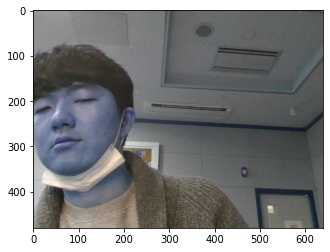

In [2]:
import matplotlib.pyplot as plt
plt.imshow(frame)

In [5]:
frame[y1:y2, x1:x2]

array([], shape=(219, 0, 3), dtype=uint8)

In [4]:
outputs[prior_index]

array([-0.00490262,  0.2826015 ,  0.28491658,  0.7387712 ,  0.03265384,
        0.43902558,  0.1811229 ,  0.41166157,  0.09123015,  0.51186484,
        0.0667306 ,  0.63099724,  0.18067579,  0.60917526,  1.        ,
        0.9999945 ], dtype=float32)

In [3]:
def draw_bbox_landm(img, ann, img_height, img_width, name, color):
    """draw bboxes and landmarks"""
    # bbox
    x1, y1, x2, y2 = int(ann[0] * img_width), int(ann[1] * img_height), \
                     int(ann[2] * img_width), int(ann[3] * img_height)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

    # confidence
    # text = "{:.4f}".format(ann[15])
    cv2.putText(img, name, (int(ann[0] * img_width), int(ann[1] * img_height)),
                cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

    # landmark
    if ann[14] > 0:
        cv2.circle(img, (int(ann[4] * img_width),
                         int(ann[5] * img_height)), 1, (255, 255, 0), 2)
        cv2.circle(img, (int(ann[6] * img_width),
                         int(ann[7] * img_height)), 1, (0, 255, 255), 2)
        cv2.circle(img, (int(ann[8] * img_width),
                         int(ann[9] * img_height)), 1, (255, 0, 0), 2)
        cv2.circle(img, (int(ann[10] * img_width),
                         int(ann[11] * img_height)), 1, (0, 100, 255), 2)
        cv2.circle(img, (int(ann[12] * img_width),
                         int(ann[13] * img_height)), 1, (255, 0, 100), 2)
        
draw_bbox_landm(frame, outputs[prior_index], frame_height, frame_width, 'name', (0,255,0))


cv2.imshow('frame', frame)
    #cv2.imshow('frame', face)
if cv2.waitKey(1) == ord('q'):
    exit()